In [1]:
# install with support for torch models
!pip install "gluonts[torch]"

# install with support for mxnet models
!pip install "gluonts[mxnet]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires num

In [1]:
import os
import pandas as pd
import numpy as np
import math

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [32]:
# Definitions and Constants
FILEPATH = '/content/sample_data/230401_250108_PT1H_Solcast_reduced_features.csv'
SEQUENCE_LENGTH = 96 # Use the past 12, 24, 48 and 96 time steps for prediction
HIDDEN_SIZE = 64 # Number of RNN cells for each layer (default: 40)
NUM_LAYERS = 2 # Number of RNN layers (default: 2)
LR = 0.001
NUM_EPOCHS = 25
LOSS = 4 # Enter manually later

In [3]:
# Helpers

# Filename extractor
def file_name_no_extension(filepath):
  # Extract the filename without the folder path
  filename_with_extension = os.path.basename(filepath)

  # Remove the `.csv` extension
  filename_without_extension = os.path.splitext(filename_with_extension)[0]

  return filename_without_extension

In [4]:
# Step 1: Load and preprocess the data
# Step 2: Feature Scaling
# Load data from a CSV file into a PandasDataset
df = pd.read_csv(FILEPATH, index_col=0, parse_dates=True,
)
#dataset = PandasDataset(dict(df), target="dc_power") #All input dimensions
#dataset = PandasDataset(df, target="dc_power") #One dimension
#dataset = PandasDataset(df, target="dc_power",
                        #past_feat_dynamic_real=['dc_power','air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'],
                        #feat_dynamic_real=['air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti', 'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water', 'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth', 'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'])
dataset = PandasDataset(df, target="dc_power",
                        past_feat_dynamic_real=['dc_power','air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'],
                        feat_dynamic_real=['air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'])

In [5]:
# Step 3: Split data into training and testing sets
# Step 4: Create test sequences for time-series prediction
TESTDATA_LENGTH = math.floor(len(df)*0.2) # 20% testdata

training_data, test_gen = split(dataset, offset=-TESTDATA_LENGTH)
test_data = test_gen.generate_instances(prediction_length=TESTDATA_LENGTH)

In [6]:
# Helper
# Calculate timestamp for Test Data starting point
timestamp_test_data = df[len(df)-TESTDATA_LENGTH:].iloc[:1].index.item()
TEST_DATA_START_DATETIME = timestamp_test_data.strftime('%Y-%m-%d %H:%M:%S')

In [33]:
# Step5: Define and Train the model

# Define the DeepAREstimator
model = DeepAREstimator(
    prediction_length=TESTDATA_LENGTH, context_length=SEQUENCE_LENGTH, freq=dataset.freq,
    trainer_kwargs={"max_epochs": NUM_EPOCHS},
    num_feat_dynamic_real=dataset.num_feat_dynamic_real,
    num_layers=NUM_LAYERS,
    hidden_size=HIDDEN_SIZE,
    lr=LR,
).train(training_data)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes     
-----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 64.5 K | train | [[1,

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 1.14680 (best 1.14680), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 1.14680 (best 1.14680), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -0.01913 (best -0.01913), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.01913 (best -0.01913), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -0.49746 (best -0.49746), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 

In [34]:
#LOSS = -0.89302

In [35]:
# Step 6: Get probabilistic predictions
forecasts = list(model.predict(test_data.input))

In [36]:
# Step 7: Get point predictions
# Get predictions from forecasts
predictions = forecasts[0].mean_ts

# Feature added here!!!
# Truncate negative predictions to 0
predictions = np.maximum(predictions, 0)

# Get actuals for metric calculations later
actuals = df[timestamp_test_data:]["dc_power"]

# Change type
predictions = predictions.to_numpy()
actuals = actuals.to_numpy()

In [37]:
# Step 8: Do evaluations
# Calculate metrics

def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).
    y_true: array-like, actual values
    y_pred: array-like, predicted values
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_values = np.abs(y_true - y_pred) / denominator
    smape_values = np.nan_to_num(smape_values, nan=0.0, posinf=0.0, neginf=0.0)  # Handle division by zero
    return np.mean(smape_values) * 100  # Convert to percentage


RMSE = np.sqrt(np.mean((predictions - actuals)**2))
MAE = mean_absolute_error(actuals, predictions)
#MAPE = np.mean(np.abs((actuals - predictions) / actuals)) * 100
R2 = r2_score(actuals, predictions)
SMAPE = smape(actuals, predictions)

# Print metrics
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")
#print(f"MAPE: {MAPE:.2f}%")
print(f"SMAPE: {SMAPE:.2f}%")
print(f"R^2: {R2:.4f}")

RMSE: 0.8630
MAE: 0.3605
SMAPE: 143.47%
R^2: 0.7117


<ipython-input-37-5386886e7caa>:10: RuntimeWarning: invalid value encountered in divide
  smape_values = np.abs(y_true - y_pred) / denominator


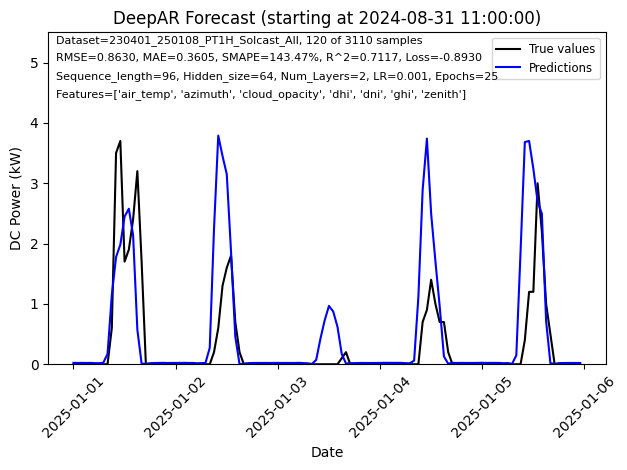

In [38]:
# Step 9: Visualize predictions first plot
start_date = "2025-01-01"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(df[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(df[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(df[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"DeepAR Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.095, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {TESTDATA_LENGTH} samples", fontsize=8, color='black')
plt.figtext(0.095, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS:.4f}", fontsize=8, color='black')
plt.figtext(0.095, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, Hidden_size={HIDDEN_SIZE}, Num_Layers={NUM_LAYERS}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.095, 0.7875,f"Features={dataset.feat_dynamic_real}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 5.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"DeepAR-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()

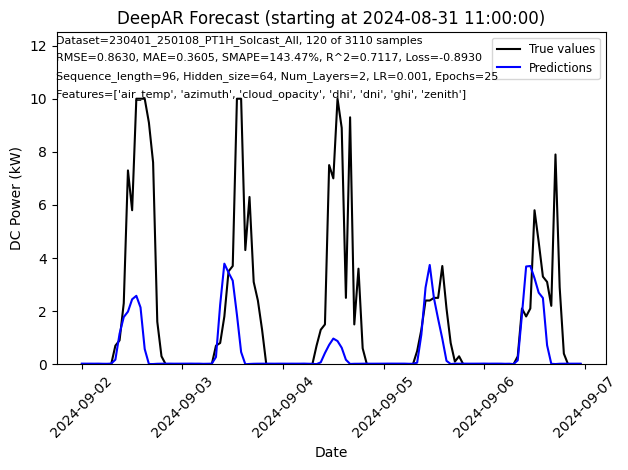

In [39]:
# Step 10: Visualize predictions second plot
start_date = "2024-09-02"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(df[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(df[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(df[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"DeepAR Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.095, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {TESTDATA_LENGTH} samples", fontsize=8, color='black')
plt.figtext(0.095, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS:.4f}", fontsize=8, color='black')
plt.figtext(0.095, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, Hidden_size={HIDDEN_SIZE}, Num_Layers={NUM_LAYERS}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.095, 0.7875,f"Features={dataset.feat_dynamic_real}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 12.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"DeepAR-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()